## Set-up 

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

In [215]:
import sklearn 
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split

In [35]:
plt.rcParams.update({"figure.figsize": (20, 6)})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Preprocessing

In [161]:
events = pd.read_csv('int20h-ds-test-dataset.csv')

In [162]:
events.head(5)

,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model
0,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Success,"{""Make"":""Dodge"",""Model"":""Caravan"",""Color"":""White"",""Year"":""2019"",""Temporary"":""false"",""Start Date"":"""",""End Date"":"""",""Rental state"":""""}",2022-01-16 17:03:04,android,samsung,SM-N975U
1,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Break,{},2022-01-16 17:07:47,android,samsung,SM-N975U
2,f344be2d9a042b7444f3cc5279e38ef1,FL,Calculator View,{},2022-01-16 17:16:25,android,samsung,SM-G973U1
3,c95c777785faec8dd910d019d7278ebe,CA,Add Payment Method Success,"{""Payment Method"":""Credit"",""Tokenized Pay"":""""}",2022-01-16 17:24:22,android,samsung,SM-N975U
4,e331ed81422d8fba55520a43a872e701,IL,Sign Up Success,"{""Method"":""Apple""}",2022-01-16 17:34:51,ios,Apple,"iPhone12,1"


In [313]:
device_manufacture = dict(events[['device_model', 'device_manufacture']].values)
device_platform = dict(events[['device_model', 'event_platform']].values)

In [356]:
set(events.loc[events['userid'] == "46c1d5ea297bd502e2d7f9dba6056bdd",'device_model'].values)

{'Alcatel_5002R', 'iPhone12,1', nan}

In [363]:
def nth_unique(n=1):
    def _nth_unique(x):
        uniq = list(set(x[x.notna()]))
        return uniq[n-1] if len(uniq) > n-1 else "None"
    return _nth_unique
    
users_info = events[['userid', 'user_state', 'device_model']].groupby('userid').agg(
    user_state=pd.NamedAgg("user_state", lambda x: pd.Series.mode(x)[0] if len(pd.Series.mode(x)) > 0 else "None"),
    device1=pd.NamedAgg("device_model", nth_unique(n=1)),
    device2=pd.NamedAgg("device_model", nth_unique(n=2)),
    device3=pd.NamedAgg("device_model", nth_unique(n=3))
)

In [365]:
for i in range(1, 4):
    users_info[f'device{i}_manufacture'] = users_info[f'device{i}'].map(device_manufacture)
    users_info[f'device{i}_platform'] = users_info[f'device{i}'].map(device_platform)

In [366]:
users_info = users_info.astype(dtype={
   col : "category" for col in users_info.columns
})

In [368]:
users_info[~(users_info['device3'] == "None")]

,user_state,device1,device2,device3,device1_manufacture,device1_platform,device2_manufacture,device2_platform,device3_manufacture,device3_platform
userid,,,,,,,,,,
423ffa8cbe761baa995e981904f479db,CA,SM-G996U1,SM-G981U,SM-G998U1,samsung,android,samsung,android,samsung,android


In [369]:
users = events[['userid', 'event_name']].groupby(['userid', 'event_name']).agg(
    count_col=pd.NamedAgg(column="event_name", aggfunc='count')
)
users = users.unstack(fill_value=0)
users.columns = [col[1] for col in users.columns]

In [370]:
users = users.join(users_info) 

In [371]:
users

,Account History Transaction Details,Account Setup Profile Skip,Account Setup Skip,Add Payment Method Failed,Add Payment Method Success,Add Vehicle Break,Add Vehicle Failed,Add Vehicle Success,Calculator Used,Calculator View,Chat Conversation Opened,Chat Conversation Started,Email Confirmation Success,Order,Reset Password Set,Sign Out,Sign Up Error,Sign Up Success,Subscription Premium,Subscription Premium Cancel,Subscription Premium Renew,Transaction Refund,Wallet Opened,user_state,device1,device2,device3,device1_manufacture,device1_platform,device2_manufacture,device2_platform,device3_manufacture,device3_platform
userid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0006869712ec9841dc36234bce245203,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,MD,SM-A716U,None,None,samsung,android,NaN,NaN,NaN,NaN
000a59897372c5e3c147b15685fefc65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,CA,"iPhone11,6",None,None,Apple,ios,NaN,NaN,NaN,NaN
001244c572f1a681553bc045a378cacf,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,FL,SM-G780G,None,None,samsung,android,NaN,NaN,NaN,NaN
0032cb66b99f6baef57ec2aa04a9277f,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,CA,"iPhone14,3",None,None,Apple,ios,NaN,NaN,NaN,NaN
003f57fe2631ade57a86f6a2b96bb20c,0,2,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,CA,"iPhone13,4",None,None,Apple,ios,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff9fd3437958123842f3ab75d22fc13f,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,CA,SM-N960U,None,None,samsung,android,NaN,NaN,NaN,NaN
ffa1aa12dd53aee84976cb6c525bb17b,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,TX,"iPhone12,1",None,None,Apple,ios,NaN,NaN,NaN,NaN
ffbbc97af52745060a9dff4eb9917f75,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,PA,"iPhone12,1",None,None,Apple,ios,NaN,NaN,NaN,NaN


## Baseline xgboost

In [383]:
users_premium = users[(users['Subscription Premium'] > 0) | 
                      (users['Subscription Premium Renew'] > 0) |
                      (users['Subscription Premium Cancel'] > 0)]

In [384]:
X = users.drop(columns=["Subscription Premium Cancel"])
y = users["Subscription Premium Cancel"] > 0

In [385]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [386]:
model = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)

In [387]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

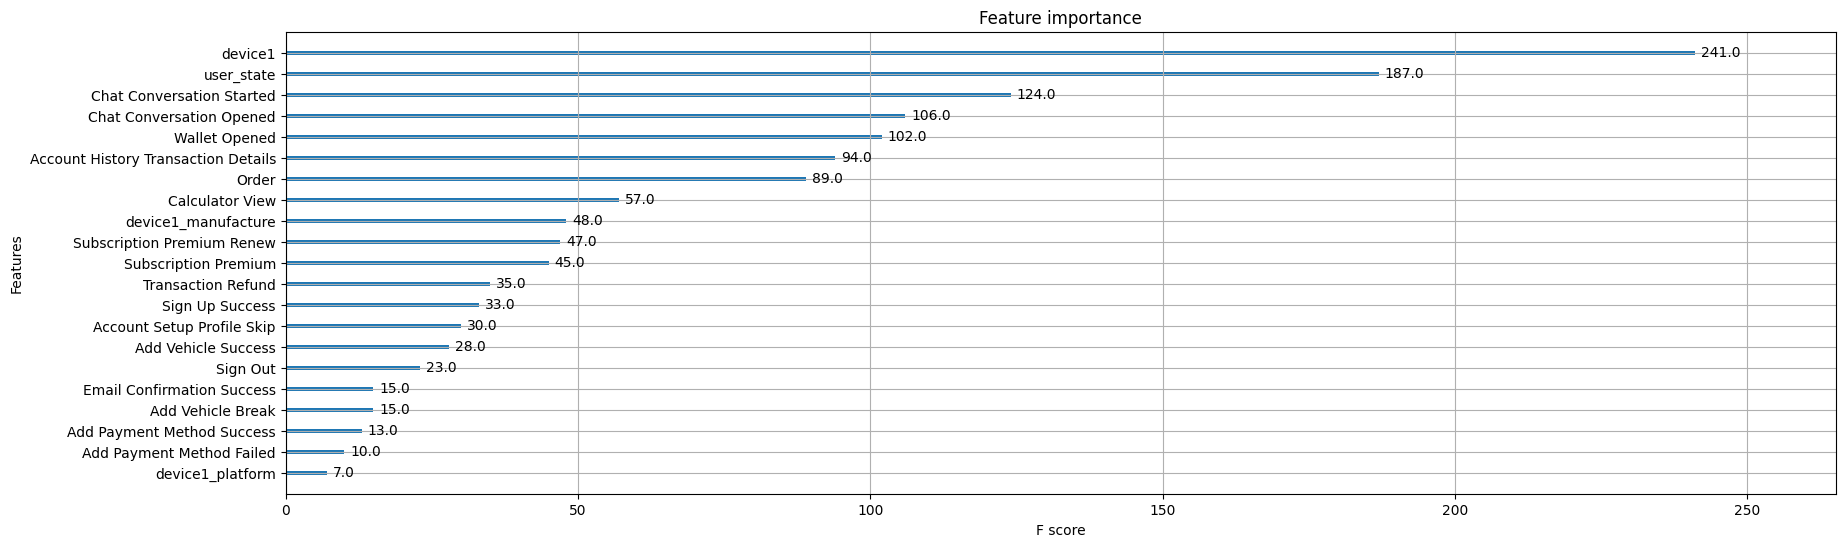

In [388]:
xgb.plot_importance(model)
plt.show()

In [389]:
y_test_pred = model.predict(X_test)

In [390]:
accuracy_score(y_test, y_test_pred)

0.9593220338983051

In [391]:
precision_score(y_test, y_test_pred), recall_score(y_test, y_test_pred)

(0.7209302325581395, 0.5636363636363636)

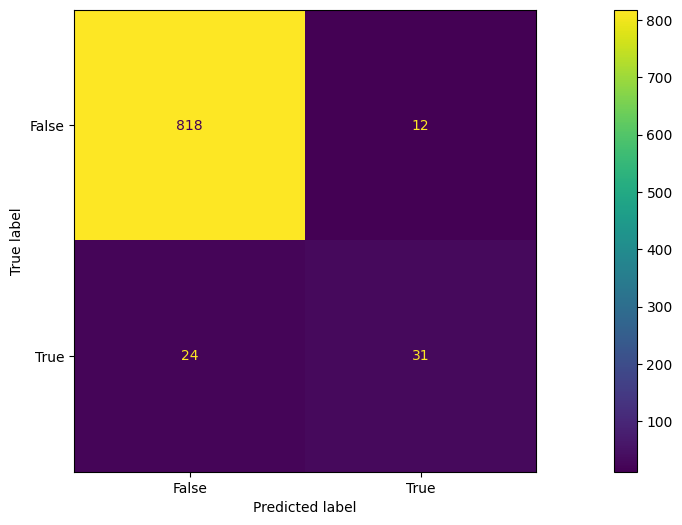

In [392]:
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)

## Devices analysis

In [265]:
model.get_booster().dump_model("booster.txt")

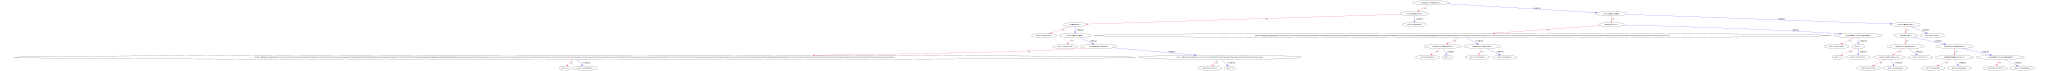

In [266]:
xgb.to_graphviz(model) 

In [233]:
devices_ids = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,242,243,244,246,248]

In [234]:
devices = pd.Series(users.device_model.cat.categories)

In [240]:
devices.drop(devices_ids)

241                     iPhone13,1
245                     iPhone14,2
247                     iPhone14,4
249                     iPhone14,6
250                      iPhone8,1
251                      iPhone8,2
252                      iPhone8,4
253                      iPhone9,1
254                      iPhone9,2
255                      iPhone9,3
256                      iPhone9,4
257                         moto e
258              moto e (XT2052DL)
259                   moto e5 plus
260             moto e6 (XT2005DL)
261                    moto g fast
262             moto g play (2021)
263            moto g power (2021)
264            moto g power (2022)
265                    moto g pure
266                  moto g stylus
267           moto g stylus (2021)
268               moto g stylus 5G
269                      moto g(6)
270                 moto g(6) play
271    moto g(7) optimo (XT1952DL)
272                 moto g(7) play
273                 moto g(7) plus
274                m

## Check random stuff

In [273]:
list(events[['event_name', 'event_attributes']].values)

[array(['Add Vehicle Success',
        '{"Make":"Dodge","Model":"Caravan","Color":"White","Year":"2019","Temporary":"false","Start Date":"","End Date":"","Rental state":""}'],
       dtype=object),
 array(['Add Vehicle Break', '{}'], dtype=object),
 array(['Calculator View', '{}'], dtype=object),
 array(['Add Payment Method Success',
        '{"Payment Method":"Credit","Tokenized Pay":""}'], dtype=object),
 array(['Sign Up Success', '{"Method":"Apple"}'], dtype=object),
 array(['Sign Up Success', '{"Method":"Google"}'], dtype=object),
 array(['Sign Up Success', '{"Method":"Google"}'], dtype=object),
 array(['Sign Up Success', '{"Method":"Google"}'], dtype=object),
 array(['Add Vehicle Success',
        '{"Make":"Ford","Model":"F-150","Temporary":"false","Color":"Black","Year":"2017"}'],
       dtype=object),
 array(['Sign Up Success', '{"Method":"Apple"}'], dtype=object),
 array(['Add Vehicle Success',
        '{"Start Date":"16/01/2022","Make":"Chevrolet","Model":"Malibu","Temporary":

## Users and devices

In [287]:
events[['userid', 'device_model']].groupby('userid').nunique().sort_values('device_model', ascending=False)

,device_model
userid,
423ffa8cbe761baa995e981904f479db,3
604062fd35365e259606987533396503,2
d29f9eabe3c60abf6285269dc49363cf,2
c1955c6e5cb8a393d9bcf8461c88c73a,2
fd4a11b9abba7352308fabf80c122501,2
...,...
b8cdde221aae75d37c0996c030e05521,0
a2e02c36f2999fdcd0f43c7d236f8b98,0
f7969f6c5da30b31f73be28b6459d221,0


In [288]:
events[['userid', 'user_state']].groupby('userid').nunique().sort_values('user_state', ascending=False)

,user_state
userid,
0006869712ec9841dc36234bce245203,1
ab48659559affb5671813091c363e359,1
aa732ee45505a789aeb6f4002d0ee3e7,1
aa7a662047b22ac923f219ba4f43b62f,1
aaaaecf9ad6c41b0db2736bf12b5b5b3,1
...,...
d9f6078c032ef4dcbed653d4187ef17e,0
c41b93b5910899817515d100c16fd8f5,0
b3cd5319263fe5aee1e1b4ed3a9e987f,0
